# 图像形成和图像恢复的模拟
在这个笔记本中，我们人为地从模拟的细胞核、噪声和背景组装一幅显微镜图像。之后，我们使用经典的图像处理技术来去除噪声和背景。

In [1]:
import pyclesperanto_prototype as cle
import numpy as np

In [2]:
image_size = (100, 100)

# noise configuration
noise_level = 2

# background configuration
camera_offset = 100
background_sigma = 25
background_intensity = 5

# nuclei configuration
nuclei_radius = 5
nuclei_blur_sigma = 1
nuclei_number = 10
nuclei_intensity = 5

In [3]:
# by pinning the random seed, we can make the code repeatable
np.random.seed(42)

## 噪声
这里我们假设图像中的噪声是[泊松分布](https://en.wikipedia.org/wiki/Poisson_distribution)的，这是显微镜学中的一个常见假设。

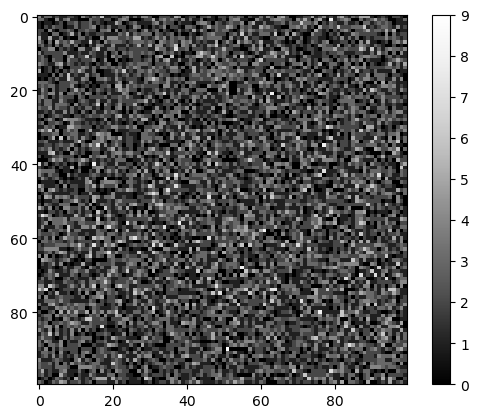

In [4]:
noise_image = np.random.poisson(noise_level, image_size)

cle.imshow(noise_image, colorbar=True)

## 背景
荧光显微镜图像中的背景强度通常来自于离焦光。我们可以通过将光源放置为单个像素并用高斯滤波器模糊它们来模拟这一点。此外，许多显微镜相机都有所谓的相机偏移。没有任何像素的强度会低于这个值。

cl.OCLArray([[102.02708 , 102.05994 , 102.09012 , ..., 100.354485, 100.342865,
        100.3312  ],
       [102.09299 , 102.12704 , 102.158325, ..., 100.38394 , 100.37136 ,
        100.358734],
       [102.1577  , 102.192924, 102.22533 , ..., 100.41521 , 100.4016  ,
        100.387955],
       ...,
       [100.162254, 100.17418 , 100.18678 , ..., 100.57553 , 100.55186 ,
        100.52856 ],
       [100.15136 , 100.16256 , 100.17441 , ..., 100.53596 , 100.51383 ,
        100.492065],
       [100.14104 , 100.15154 , 100.16266 , ..., 100.49834 , 100.477684,
        100.457375]], dtype=float32)
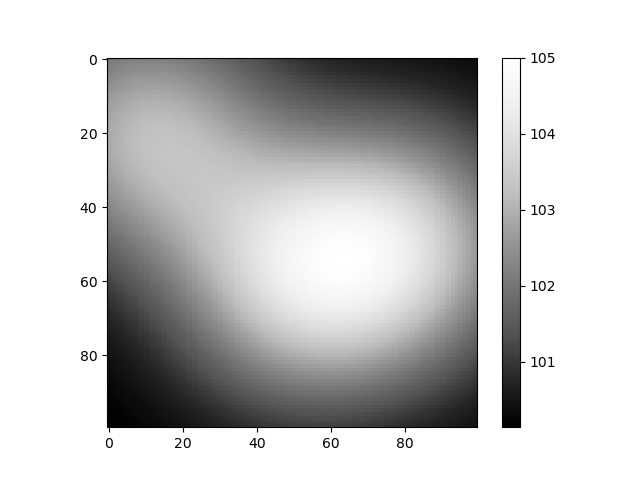
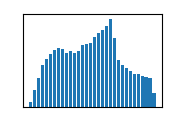

In [5]:
# create empty image
background = np.zeros(image_size)

# place light sources
background[20, 10] += 1
background[50, 80] += 1
background[60, 50] += 1

# blur them massively
background = cle.gaussian_blur(background, sigma_x=background_sigma, sigma_y=background_sigma)

# normalize the image so that the maximum intensity has a defined value
background = background / background.max() * background_intensity

# add camera offsert
background = background + camera_offset

background

## 细胞核
接下来，我们在图像中随机位置放置细胞核。我们稍微模糊它们以模拟显微镜的[点扩散函数](https://en.wikipedia.org/wiki/Point_spread_function)。

cl.OCLArray([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
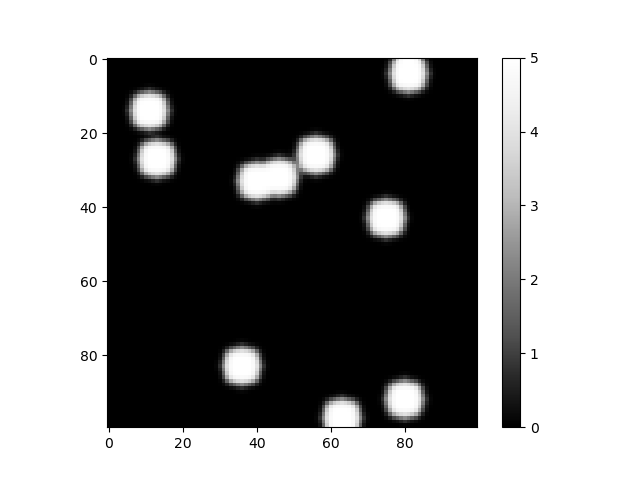
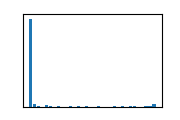

In [6]:
# retrieve a defined number of random positions
nuclei_positions = np.random.random((nuclei_number, 2)) * image_size

# write 1 at these locations
nuclei_image = cle.pointlist_to_labelled_spots(nuclei_positions.T, np.zeros(image_size))
nuclei_image = (nuclei_image > 0) * nuclei_intensity

# enlarge the nuclei by a define radius
nuclei_image = cle.maximum_sphere(nuclei_image, radius_x=nuclei_radius, radius_y=nuclei_radius)

# blur the image to make it look more realistic
nuclei_image = cle.gaussian_blur(nuclei_image, sigma_x=nuclei_blur_sigma, sigma_y=nuclei_blur_sigma)

nuclei_image

## 图像形成
显微镜图像是场景和上述效果的总和。

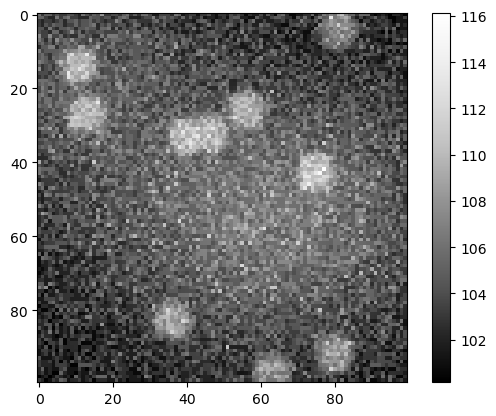

In [7]:
sum_image = np.asarray(noise_image + background + nuclei_image)

cle.imshow(sum_image, colorbar=True)

## 图像分割
如果我们现在直接对这个图像应用分割算法，可能会导致错误的结果。

cl.OCLArray([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
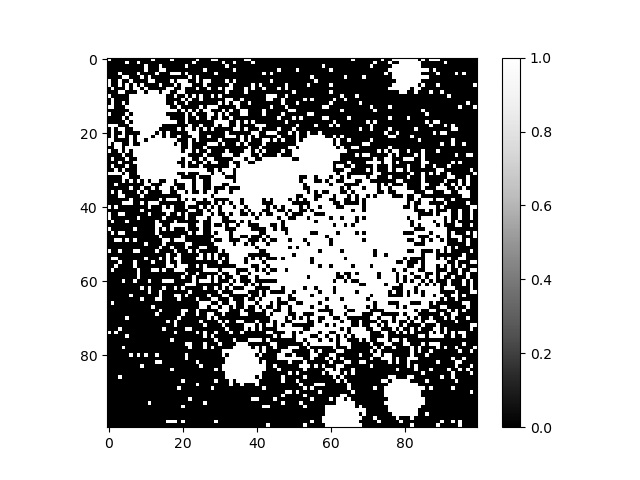
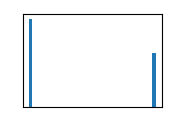

In [8]:
binary = cle.threshold_otsu(sum_image.astype(np.float32))

binary

## 背景去除
为了解决这个问题，我们首先需要去除背景强度。

cl.OCLArray([[3.8403397 , 0.87319946, 2.9033813 , ..., 1.9769974 , 0.9653778 ,
        0.        ],
       [2.90625   , 2.9403    , 0.97158813, ..., 0.98750305, 0.9749222 ,
        2.9622955 ],
       [0.9647751 , 0.        , 0.94418335, ..., 0.98648834, 0.97288513,
        0.95923615],
       ...,
       [1.9481506 , 2.9600754 , 0.97267914, ..., 1.9328156 , 1.9091415 ,
        0.88584137],
       [0.        , 0.9756546 , 1.987503  , ..., 0.        , 0.        ,
        1.9782333 ],
       [2.9896774 , 1.988884  , 0.        , ..., 1.9623795 , 2.963852  ,
        0.9435425 ]], dtype=float32)
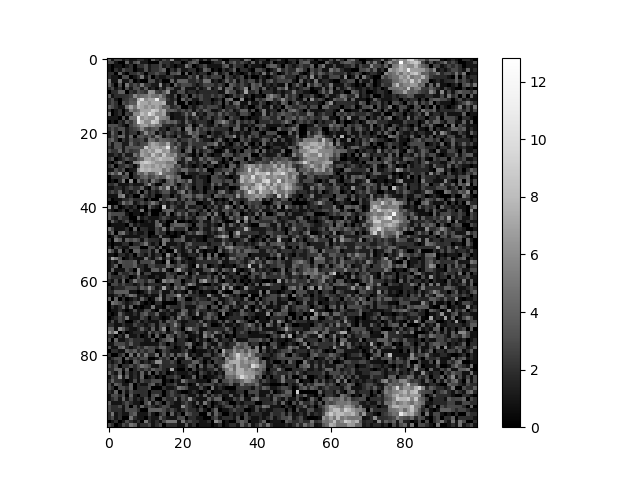
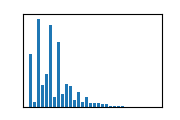

In [9]:
background_removed = cle.top_hat_box(sum_image, radius_x=10, radius_y=10)

background_removed

## 噪声去除
我们还可以从图像中去除噪声。

cl.OCLArray([[104.74284 , 104.3482  , 104.095535, ..., 101.47704 , 101.363914,
        101.35629 ],
       [104.30064 , 104.044365, 103.93013 , ..., 101.66889 , 101.658714,
        101.65071 ],
       [104.04146 , 103.820206, 103.74111 , ..., 101.83249 , 101.82167 ,
        101.675224],
       ...,
       [102.205376, 101.97187 , 101.775345, ..., 102.33887 , 102.285355,
        101.99471 ],
       [101.98917 , 101.82425 , 101.76516 , ..., 102.513435, 102.288475,
        102.136536],
       [102.05105 , 101.98929 , 101.72292 , ..., 102.66122 , 102.23012 ,
        101.940834]], dtype=float32)
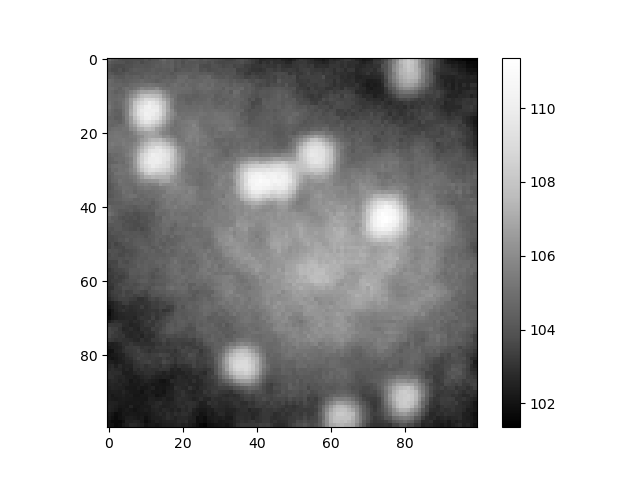
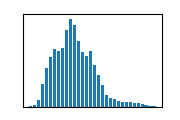

In [10]:
noise_removed1 = cle.mean_sphere(sum_image, radius_x=3, radius_y=3)

noise_removed1

这也可以在背景减去后的图像上进行。

cl.OCLArray([[2.5495512, 2.1518824, 1.8934631, ..., 1.0838996, 0.9818381,
        0.9806079],
       [2.0891273, 1.8271031, 1.7071246, ..., 1.2431078, 1.249447 ,
        1.2490945],
       [1.7942544, 1.5672424, 1.4824032, ..., 1.3784474, 1.3799691,
        1.2459035],
       ...,
       [1.9805651, 1.7442198, 1.5428588, ..., 1.6989396, 1.6650388,
        1.3941103],
       [1.7917184, 1.6217978, 1.5557053, ..., 1.914941 , 1.7043592,
        1.5668714],
       [1.8778669, 1.8098779, 1.5343451, ..., 2.0801234, 1.6664302,
        1.393364 ]], dtype=float32)
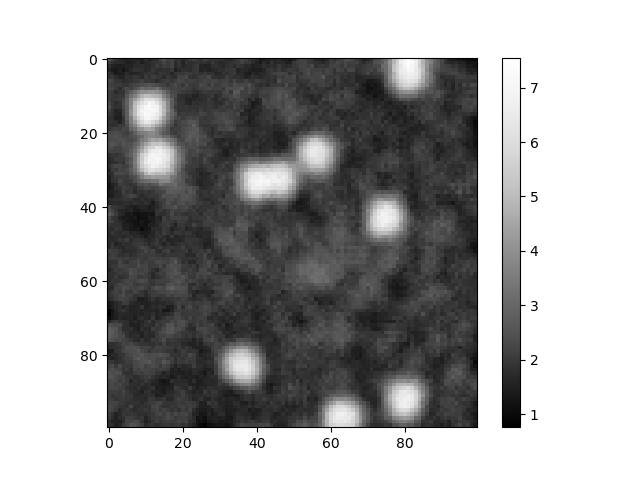
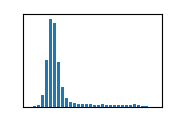

In [11]:
noise_removed = cle.mean_sphere(background_removed, radius_x=3, radius_y=3)

noise_removed

## 图像分割 II
在校正图像后，我们可以再次尝试分割。

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
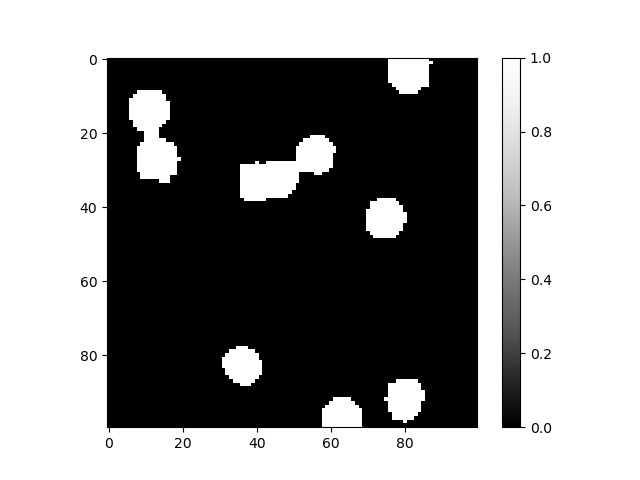
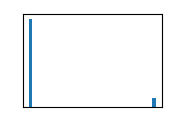

In [12]:
binary2 = cle.threshold_otsu(noise_removed.astype(np.float32))

binary2

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


StackViewNDArray([[False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  ...,
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False]])
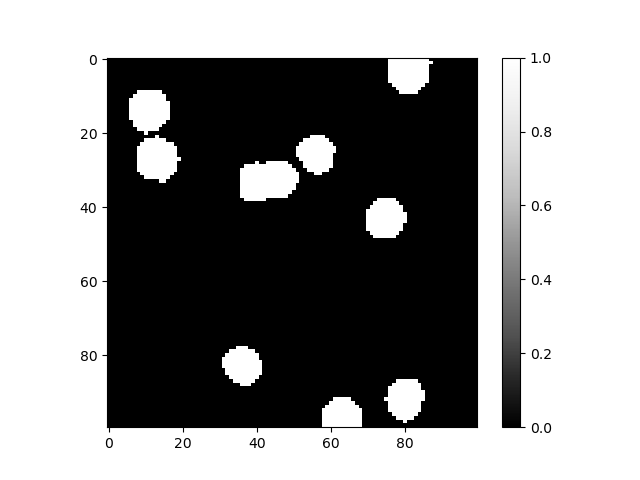
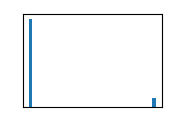

In [13]:
# sneak preview: watershed
import napari_segment_blobs_and_things_with_membranes as nsbatwm
binary3 = nsbatwm.split_touching_objects(binary2)

binary3